In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [3]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"

#Gas Prices 
spot_gas = "eex_spot_gas.csv"
d_ahead_gas = "eex_gas_d.csv"
m_ahead_gas = "eex_gas_m.csv"
y_ahead_gas = "eex_gas_y.csv"

#Power Prices
spot_power = "epex_spot_power.csv"
d_ahead_peak = "eex_power_peak_d.csv"
m_ahead_peak = "eex_power_peak_m.csv"
y_ahead_peak = "eex_power_peak_y.csv"
d_ahead_base = "eex_power_base_d.csv"
m_ahead_base = "eex_power_base_m.csv"
y_ahead_base = "eex_power_base_y.csv"

#Master files
master_power = 'master_competitor_market_prices_power.csv'
master_gas = 'master_competitor_market_prices_gas.csv'


In [4]:
#Reading in power dataset
df_power = pd.read_csv(path + master_power)
df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,...,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak,avg_price,price_kwh,strat_index,validity_period
0,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.520500,2,119
1,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.515700,2,119
2,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.515700,2,119
3,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.750480,2,120
4,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,...,0.02646,0.03165,0.06402,0.07535,0.07028,0.09030,0.058416,0.745680,2,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33161801,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.771421,2,0
33161802,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.781322,2,0
33161803,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.764625,2,0
33161804,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,...,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528,0.678392,3,0


In [5]:
def queryPostCodeSupplier(post_code = 81737, supplier = 'Sarma') -> pd.DataFrame:
    res = df_power.loc[(df_power.post_code == post_code) & (df_power.supplier == supplier)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean', 'spot_base':'mean', 'y_ahead_base':'mean', 'd_ahead_base':'mean', 'm_ahead_base':'mean', '6m_ahead_base':'mean'})
    return res

In [6]:
df = queryPostCodeSupplier()
df.set_index(pd.to_datetime(df.index))
df = df/1000
df.price_kwh = df.price_kwh * 1000
df

,price_kwh,spot_base,y_ahead_base,d_ahead_base,m_ahead_base,6m_ahead_base
valid_range,,,,,,
2021-08-13,0.434600,0.000107,0.000083,0.000107,0.000097,0.000104
2021-08-14,0.434600,0.000107,0.000083,0.000107,0.000097,0.000104
2021-08-15,0.434600,0.000107,0.000083,0.000107,0.000097,0.000104
2021-08-16,0.434600,0.000107,0.000083,0.000107,0.000097,0.000104
2021-08-17,0.434600,0.000107,0.000083,0.000107,0.000097,0.000104
...,...,...,...,...,...,...
2022-10-09,0.748727,0.000158,0.000434,0.000158,0.000372,0.000395
2022-10-10,0.748727,0.000158,0.000434,0.000158,0.000372,0.000395
2022-10-13,0.758761,0.000283,0.000434,0.000283,0.000342,0.000390


(0.45775131455944706, True)

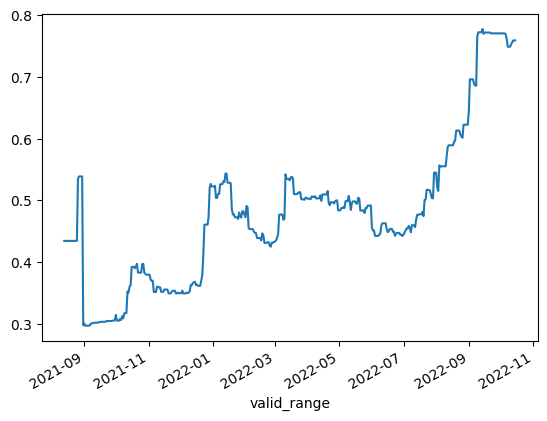

In [7]:
#Plotting timeseries
df.price_kwh.plot()

#Checking for stationarity (p-value lower than 0.05 means that time series is not stationary)
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df[['price_kwh']])

In [8]:
#Defining train and test splits
train, test = train_test_split(df, train_size= int(0.85*df.shape[0]))
y_train = pd.Series(train['price_kwh'], index = train.index)
y_test = pd.Series(test['price_kwh'], index = test.index)
x_train = train.drop(columns=['price_kwh'])
x_test = test.drop(columns=['price_kwh'])

In [9]:
model = pm.auto_arima(y_train, x_train, m = 1, random_state=42, d = 2)
preds = model.predict(x_test.shape[0], x_test)
preds.index = x_test.index
preds

/Users/michaelfuest/DAiA-EON/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


valid_range
2022-08-11    0.551011
2022-08-12    0.540916
2022-08-13    0.536950
2022-08-14    0.536943
2022-08-15    0.536954
                ...   
2022-10-09    0.591668
2022-10-10    0.591677
2022-10-13    0.580064
2022-10-14    0.580073
2022-10-15    1.159360
Length: 64, dtype: float64

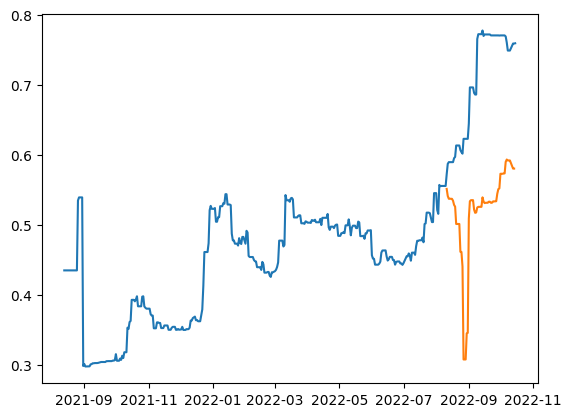

In [10]:
plt.plot(df.price_kwh)
plt.plot(preds[:-1])
plt.show()

In [83]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3) #this is the range for the values
q_values = range(0, 3) #this is the range for the values

def evaluate_arima_model(X, arima_order):
    #Defining exogenous values
    exo = X.drop(columns=['price_kwh'])
    timeseries = np.array(X.price_kwh)

    # prepare training dataset
    train_size = int(len(timeseries) * 0.66)
    train, test = timeseries[:train_size], timeseries[train_size:]
    
    exo_train, exo_test = exo[:train_size], exo[train_size:]
    exo_test.reset_index(inplace = True)
    history = [x for x in train]
    exo_history = exo_train

    print(exo_history.shape)
    print(len(history))

    # make predictions
    predictions = []
    for t in range(len(test)):
        print(len(history))
        print(exo_history.shape)
        model = ARIMA(history, exog = exo_history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(exog = exo_test.iloc[t])[0]
        predictions.append(yhat)
        history.append(test[t])
        pd.concat([exo_history, exo_test.iloc[t]], axis = 0)

    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


#evaluate_models(df, p_values, d_values, q_values)

In [84]:
evaluate_arima_model(df, (1,1,1))

(280, 5)
280
280
(280, 5)


/Users/michaelfuest/DAiA-EON/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/michaelfuest/DAiA-EON/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/michaelfuest/DAiA-EON/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 5), got (6,).

In [48]:
type(df.iloc[3])

pandas.core.series.Series